## Imports

In [1]:
import copy
import logging
from pathlib import Path
from typing import Dict
import math

import hydra
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import omegaconf
import seaborn as sns
import torch  # noqa
import wandb
from hydra.utils import instantiate
from matplotlib import tri
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from omegaconf import DictConfig
from pytorch_lightning import LightningModule
from scipy.stats import qmc
from torch.utils.data import DataLoader
from tqdm import tqdm
from ccmm.matching.utils import perm_indices_to_perm_matrix
from ccmm.utils.utils import normalize_unit_norm, project_onto

from nn_core.callbacks import NNTemplateCore
from nn_core.common import PROJECT_ROOT
from nn_core.common.utils import seed_index_everything
from nn_core.model_logging import NNLogger
from ccmm.utils.utils import fuse_batch_norm_into_conv
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler

import ccmm  # noqa
from ccmm.matching.utils import (
    apply_permutation_to_statedict,
    get_all_symbols_combinations,
    plot_permutation_history_animation,
    restore_original_weights,
)
from ccmm.utils.utils import (
    linear_interpolate_state_dicts,
    load_model_from_info,
    map_model_seed_to_symbol,
    save_factored_permutations,
)

from ccmm.matching.utils import load_permutations

from ccmm.utils.utils import vector_to_state_dict
import pytorch_lightning

/home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
matplotlib.rcParams["font.family"] = "serif"
sns.set_context("talk")
cmap_name = "coolwarm_r"

logging.getLogger("lightning.pytorch").setLevel(logging.WARNING)
logging.getLogger("torch").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)
pylogger = logging.getLogger(__name__)

## Configuration

In [3]:
%load_ext autoreload
%autoreload 2

import hydra
from hydra import initialize, compose
from typing import Dict, List

hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path=str("../conf"), job_name="matching_n_models")

hydra.initialize()

In [4]:
cfg = compose(config_name="matching_n_models", overrides=[])

In [5]:
core_cfg = cfg  # NOQA
cfg = cfg.matching

seed_index_everything(cfg)

2024-02-02 09:13:13 INFO     Global seed set to 1608637542                      ]8;id=169641;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py\pytorch_lightning.utilities.seed]8;;\:]8;id=716721;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/utilities/seed.py#71\71]8;;\

                    INFO     Setting seed 1608637542 from seeds[0]                         ]8;id=506654;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/nn_core/common/utils.py\nn_core.common.utils]8;;\:]8;id=125355;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/nn_core/common/utils.py#107\107]8;;\

1608637542

## Hyperparameters

In [6]:
num_test_samples = 5000
num_train_samples = 5000

## Load dataset

In [7]:
transform = instantiate(core_cfg.dataset.test.transform)

train_dataset = instantiate(core_cfg.dataset.train, transform=transform)
test_dataset = instantiate(core_cfg.dataset.test, transform=transform)

train_subset = Subset(train_dataset, list(range(num_train_samples)))
train_loader = DataLoader(train_subset, batch_size=5000, num_workers=cfg.num_workers)

test_subset = Subset(test_dataset, list(range(num_test_samples)))

test_loader = DataLoader(test_subset, batch_size=1000, num_workers=cfg.num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainer = instantiate(cfg.trainer, enable_progress_bar=False, enable_model_summary=False)

/home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(


2024-02-02 09:13:14 INFO     GPU available: True (cuda), used: True      ]8;id=552910;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=345024;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1751\1751]8;;\

                    INFO     TPU available: False, using: 0 TPU cores    ]8;id=346224;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=130475;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1754\1754]8;;\

                    INFO     IPU available: False, using: 0 IPUs         ]8;id=224430;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=170108;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1757\1757]8;;\

                    INFO     HPU available: False, using: 0 HPUs         ]8;id=500215;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py\pytorch_lightning.utilities.rank_zero]8;;\:]8;id=635995;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py#1760\1760]8;;\

## Load models

In [9]:
from ccmm.utils.utils import load_model_from_artifact

run = wandb.init(project=core_cfg.core.project_name, entity=core_cfg.core.entity, job_type="matching")

# {a: 1, b: 2, c: 3, ..}
symbols_to_seed: Dict[int, str] = {map_model_seed_to_symbol(seed): seed for seed in cfg.model_seeds}

artifact_path = (
    lambda seed: f"{core_cfg.core.entity}/{core_cfg.core.project_name}/{core_cfg.model.model_identifier}_{seed}:v0"
)

# {a: model_a, b: model_b, c: model_c, ..}
models: Dict[str, LightningModule] = {
    map_model_seed_to_symbol(seed): load_model_from_artifact(run, artifact_path(seed)) for seed in cfg.model_seeds
}

num_models = len(models)

pylogger.info(f"Using {num_models} models with architecture {core_cfg.model.model_identifier}")

                    ERROR    Failed to detect the name of this notebook, you can set it manually  ]8;id=524143;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/wandb/jupyter.py\wandb.jupyter]8;;\:]8;id=591644;file:///home/daniele/miniconda3/envs/ccmm/lib/python3.9/site-packages/wandb/jupyter.py#224\224]8;;\
                             with the WANDB_NOTEBOOK_NAME environment variable to enable code                      
                             saving.                                                                               

wandb: Currently logged in as: dbaieri (gladia). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


2024-02-02 09:13:38 INFO     Using 3 models with architecture ResNet22_4                                ]8;id=263442;file:///tmp/ipykernel_3705/4016701784.py\__main__]8;;\:]8;id=560796;file:///tmp/ipykernel_3705/4016701784.py#19\19]8;;\

In [10]:
# always permute the model having larger character order, i.e. c -> b, b -> a and so on ...
symbols = set(symbols_to_seed.keys())
sorted_symbols = sorted(symbols, reverse=False)

# (a, b), (a, c), (b, c), ...
all_combinations = get_all_symbols_combinations(symbols)
# combinations of the form (a, b), (a, c), (b, c), .. and not (b, a), (c, a) etc
canonical_combinations = [(source, target) for (source, target) in all_combinations if source < target]

## Matching

In [11]:
pylogger.info(f"Matching the following model pairs: {canonical_combinations}")

2024-02-02 09:13:39 INFO     Matching the following model pairs: [('a', 'b'), ('a', 'c'), ('b', 'c')]    ]8;id=527597;file:///tmp/ipykernel_3705/3712436184.py\__main__]8;;\:]8;id=234146;file:///tmp/ipykernel_3705/3712436184.py#1\1]8;;\

### Load permutation specification

In [12]:
permutation_spec_builder = instantiate(core_cfg.model.permutation_spec_builder)
permutation_spec = permutation_spec_builder.create_permutation()

ref_model = list(models.values())[0]
assert set(permutation_spec.layer_and_axes_to_perm.keys()) == set(ref_model.model.state_dict().keys())

In [13]:
matcher = instantiate(cfg.matcher, permutation_spec=permutation_spec)
pylogger.info(f"Matcher: {matcher.name}")

                    INFO     Matcher: frank_wolfe                                                        ]8;id=303714;file:///tmp/ipykernel_3705/1001963601.py\__main__]8;;\:]8;id=944046;file:///tmp/ipykernel_3705/1001963601.py#2\2]8;;\

In [14]:
permutations, perm_history = matcher(models, symbols=sorted_symbols, combinations=canonical_combinations)

Weight matching: 100%|██████████| 200/200 [02:54<00:00,  1.15it/s]


In [15]:
models = {symb: model.to("cpu") for symb, model in models.items()}

### Permute models to universe

In [16]:
from ccmm.matching.utils import perm_matrix_to_perm_indices

models_permuted_to_universe = {symbol: copy.deepcopy(model) for symbol, model in models.items()}

for symbol, model in models_permuted_to_universe.items():
    perms_to_universe = {}

    for perm_name, perm in permutations[symbol].items():
        perm = perm_indices_to_perm_matrix(perm)
        perm_to_universe = perm.T
        perm_to_universe = perm_matrix_to_perm_indices(perm_to_universe)
        perms_to_universe[perm_name] = perm_to_universe

    permuted_params = apply_permutation_to_statedict(permutation_spec, perms_to_universe, model.model.state_dict())
    models_permuted_to_universe[symbol].model.load_state_dict(permuted_params)

### Permute models pairwise

In [17]:
from ccmm.matching.utils import unfactor_permutations

models_permuted_pairwise = {
    symbol: {other_symb: None for other_symb in set(symbols).difference(symbol)} for symbol in symbols
}
pairwise_permutations = unfactor_permutations(permutations)

for fixed, permutee in all_combinations:
    ref_model = copy.deepcopy(models["a"])

    permuted_params = apply_permutation_to_statedict(
        permutation_spec, pairwise_permutations[fixed][permutee], models[permutee].model.state_dict()
    )

    ref_model.model.load_state_dict(permuted_params)
    models_permuted_pairwise[fixed][permutee] = ref_model

/home/daniele/source/cycle-consistent-model-merging/src/ccmm/matching/utils.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  permutations[symbol][perm_name] = torch.tensor(perm)


### Check performance of models before and after permutation

In [18]:
for symbol, model in models_permuted_to_universe.items():
    trainer.test(models_permuted_to_universe[symbol], test_loader)
    trainer.test(models[symbol], test_loader)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │     0.91839998960495      │
│         loss/test         │    0.34458667039871216    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │     0.91839998960495      │
│         loss/test         │    0.3445866107940674     │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9115999937057495     │
│         loss/test         │    0.3762316405773163     │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9115999937057495     │
│         loss/test         │    0.3762316107749939     │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9254000186920166     │
│         loss/test         │    0.32126373052597046    │
└───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         acc/test          │    0.9254000186920166     │
│         loss/test         │    0.32126373052597046    │
└───────────────────────────┴───────────────────────────┘

## Analyze models as vectors

### Flatten models

In [19]:
other_symbs = {symbol: set(symbols).difference(symbol) for symbol in symbols}
print(other_symbs)

{'b': {'c', 'a'}, 'c': {'b', 'a'}, 'a': {'b', 'c'}}


In [20]:
flat_models = {symbol: torch.nn.utils.parameters_to_vector(model.parameters()) for symbol, model in models.items()}
flat_models_permuted_to_universe = {
    symbol: torch.nn.utils.parameters_to_vector(model.parameters())
    for symbol, model in models_permuted_to_universe.items()
}

flat_models_permuted_pairwise = {
    symbol: {
        other_symb: torch.nn.utils.parameters_to_vector(models_permuted_pairwise[symbol][other_symb].parameters())
        for other_symb in other_symbs[symbol]
    }
    for symbol in symbols
}

In [21]:
flat_models_permuted_pairwise["e"].keys()

KeyError: 'e'

In [22]:
for symbol in symbols:
    flat_models_permuted_pairwise[symbol][symbol] = flat_models[symbol]
    models_permuted_pairwise[symbol][symbol] = models[symbol]

## Interpolation curves

In [33]:
def linear_interpolation(model_a, model_b, lamb):
    return (1 - lamb) * model_a + lamb * model_b


def get_interp_curve(lambdas, model_a, model_b, ref_model):

    interp_losses = []
    interp_accs = []

    for lamb in lambdas:
        interp_params = linear_interpolation(model_a=model_a, model_b=model_b, lamb=lamb)

        interp_params = vector_to_state_dict(interp_params, ref_model.model)

        ref_model.model.load_state_dict(interp_params)
        results = trainer.test(ref_model, test_loader, verbose=False)

        interp_losses.append(results[0][f"loss/test"])
        interp_accs.append(results[0][f"acc/test"])

    return interp_losses, interp_accs

In [24]:
lambdas = np.linspace(0, 1, 3)
loss_curve_a_univ_c_univ, acc_curve_a_univ_c_univ = get_interp_curve(
    lambdas=lambdas,
    model_a=flat_models_permuted_to_universe["a"],
    model_b=flat_models_permuted_to_universe["c"],
    ref_model=ref_model,
)
loss_curve_a_univ_d_univ, acc_curve_a_univ_d_univ = get_interp_curve(
    lambdas=lambdas,
    model_a=flat_models_permuted_to_universe["b"],
    model_b=flat_models_permuted_to_universe["c"],
    ref_model=ref_model,
)
loss_curve_a_perm_c, acc_curve_a_perm_c = get_interp_curve(
    lambdas=lambdas, model_a=flat_models["a"], model_b=flat_models_permuted_pairwise["a"]["c"], ref_model=ref_model
)
loss_curve_a_b, acc_curve_a_b = get_interp_curve(
    lambdas=lambdas, model_a=flat_models["a"], model_b=flat_models["c"], ref_model=ref_model
)

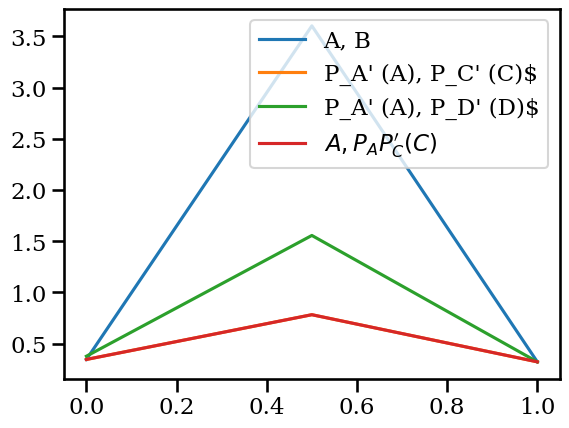

In [25]:
plt.plot(lambdas, loss_curve_a_b, label=r"A, B")
plt.plot(lambdas, loss_curve_a_univ_c_univ, label=r"P_A' (A), P_C' (C)$")
plt.plot(lambdas, loss_curve_a_univ_d_univ, label=r"P_A' (A), P_D' (D)$")
plt.plot(lambdas, loss_curve_a_perm_c, label=r"$A, P_A P_C' (C)$")
plt.legend()

In [51]:
# plt.plot(lambdas, acc_curve_a_b, label=r"$A, B$")
# plt.plot(lambdas, acc_curve_a_univ_c_univ, label=r"$P_{A}^\top (A), P_{C}^\top (C)$")
# plt.plot(lambdas, acc_curve_a_univ_d_univ, label=r"$P_{A}^\top (A), P_{D}^\top (D)$")
# plt.plot(lambdas, acc_curve_a_perm_c, label=r"$A, P_{A} P_{C}^\top (C)$")
# plt.legend()

def plot_lmc(lambdas, function, source, target):
    for i in range(len(lambdas)):
        plt.plot(lambdas[i], function[i], label=f"{source[i]}, {target[i]}"'--',alpha=i*0.1+0.3,linewidth=3-i*0.2)
    plt.legend(prop={'size': 10})

In [27]:
'''
from ccmm.utils.utils import average_models


for ref_symbol in symbols:

    ref_model = copy.deepcopy(models[ref_symbol])

    all_models_permuted_to_ref = {symb: models_permuted_pairwise[ref_symbol][symb] for symb in symbols}

    model_params = {symbol: model.state_dict() for symbol, model in all_models_permuted_to_ref.items()}

    mean_params = average_models(model_params)

    ref_model.load_state_dict(mean_params)

    results = trainer.test(ref_model, test_loader, verbose=True)
'''

'\nfrom ccmm.utils.utils import average_models\n\n\nfor ref_symbol in symbols:\n\n    ref_model = copy.deepcopy(models[ref_symbol])\n\n    all_models_permuted_to_ref = {symb: models_permuted_pairwise[ref_symbol][symb] for symb in symbols}\n\n    model_params = {symbol: model.state_dict() for symbol, model in all_models_permuted_to_ref.items()}\n\n    mean_params = average_models(model_params)\n\n    ref_model.load_state_dict(mean_params)\n\n    results = trainer.test(ref_model, test_loader, verbose=True)\n'

In [27]:
%%capture

from ccmm.matching.weight_matching import PermutationSpec, weight_matching
from ccmm.matching.utils import get_inverse_permutations


pairwise_perms_gitrebasin = {
 symb: {other_symb: None for other_symb in set(symbols).difference(symb)} for symb in symbols   
}

for fixed, permutee in canonical_combinations:
    permutation = weight_matching(
        permutation_spec,
        fixed=models[fixed].model.state_dict(),
        permutee=models[permutee].model.state_dict(),
    )
    pairwise_perms_gitrebasin[fixed][permutee] = permutation
    pairwise_perms_gitrebasin[permutee][fixed] = get_inverse_permutations(permutation)
    

In [28]:
def cyclic_permute(pairwise_perms, symbols, models):
    ordered_symbs = sorted(list(symbols))
    model_current = models[ordered_symbs[0]].model.state_dict()
    for i, symb in enumerate(ordered_symbs[1:] + [ordered_symbs[0]]):
        # print("next: {} -- prev: {}".format(symb, ordered_symbs[i]))
        permutation = pairwise_perms[symb][ordered_symbs[i]]
        model_current = apply_permutation_to_statedict(
            permutation_spec, permutation, model_current
        )
    return model_current

In [29]:

def evaluate_interpolated_model(lambd, model_a, model_b, ref_model):

    interp_params = linear_interpolate_state_dicts(
        t1=model_a.model.state_dict(), t2=model_b.model.state_dict(), lam=lambd
    )

    ref_model.model.load_state_dict(interp_params)

    test_results = trainer.test(ref_model, test_loader, verbose=False)[0]

    return test_results

def get_interp_curve(lambdas, model_a, model_b, ref_model):

    interp_losses = []
    interp_accs = []

    for lamb in lambdas:
        interp_results = evaluate_interpolated_model(model_a=model_a, model_b=model_b, lambd=lamb, ref_model=ref_model)

        interp_losses.append(interp_results[f"loss/test"])
        interp_accs.append(interp_results[f"acc/test"])

    return interp_losses, interp_accs

def l2_norm_models(state_dict1, state_dict2):
    """Calculate the L2 norm of the difference between two state dictionaries."""
    diff_squared_sum = sum(torch.sum((state_dict1[key] - state_dict2[key]) ** 2) for key in state_dict1)
    return torch.sqrt(diff_squared_sum)


In [ ]:
a_cycle_ours = cyclic_permute(pairwise_permutations, ['a', 'b', 'c'], models)
a_cycle_gitr = cyclic_permute(pairwise_perms_gitrebasin, ['a', 'b', 'c'], models)

initial_model = models['a']
permuted_model_ours = copy.deepcopy(initial_model)
permuted_model_ours.model.load_state_dict(a_cycle_ours)
permuted_model_gitr = copy.deepcopy(initial_model)
permuted_model_gitr.model.load_state_dict(a_cycle_gitr)

lambdas = np.linspace(0, 1, 25)
loss_cycle_ours, acc_cycle_ours = get_interp_curve(
    lambdas=lambdas,
    model_a=initial_model,
    model_b=permuted_model_ours,
    ref_model=ref_model,
)
loss_cycle_gitr, acc_cycle_gitr = get_interp_curve(
    lambdas=lambdas,
    model_a=initial_model,
    model_b=permuted_model_gitr,
    ref_model=ref_model,
)


In [ ]:

plot_lmc([lambdas] * 2, [loss_cycle_ours, loss_cycle_gitr], ['A', 'A'], ['cycle(abc, frank-wolfe)', 'cycle(abc, git-rebasin)'])

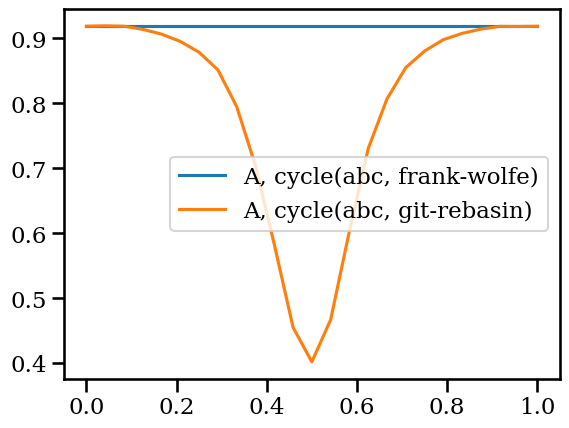

In [31]:

plot_lmc([lambdas] * 2, [acc_cycle_ours, acc_cycle_gitr], ['A', 'A'], ['cycle(abc, frank-wolfe)', 'cycle(abc, git-rebasin)'])

In [38]:
%%capture

model_a = flat_models['a']
model_b = flat_models['b']
model_c = flat_models['c']
a_univ = flat_models_permuted_to_universe['a']
b_univ = flat_models_permuted_to_universe['b']
c_univ = flat_models_permuted_to_universe['c']


loss_ac, acc_ac = get_interp_curve(
    lambdas=lambdas,
    model_a=model_a,
    model_b=model_c,
    ref_model=ref_model,
)
loss_a_univ_c_univ, acc_a_univ_c_univ = get_interp_curve(
    lambdas=lambdas,
    model_a=a_univ,
    model_b=c_univ,
    ref_model=ref_model,
)
loss_bc, acc_bc = get_interp_curve(
    lambdas=lambdas,
    model_a=model_b,
    model_b=model_c,
    ref_model=ref_model,
)
loss_b_univ_c_univ, acc_b_univ_c_univ = get_interp_curve(
    lambdas=lambdas,
    model_a=b_univ,
    model_b=c_univ,
    ref_model=ref_model,
)
loss_ab, acc_ab = get_interp_curve(
    lambdas=lambdas,
    model_a=model_a,
    model_b=model_b,
    ref_model=ref_model,
)
loss_a_univ_b_univ, acc_a_univ_b_univ = get_interp_curve(
    lambdas=lambdas,
    model_a=a_univ,
    model_b=b_univ,
    ref_model=ref_model,
)

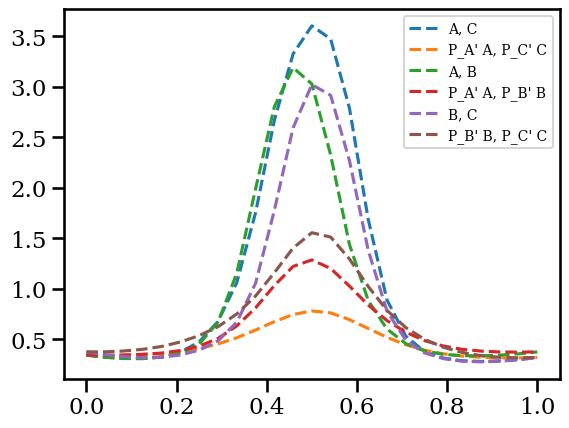

In [52]:

plot_lmc([lambdas] * 6, 
         [loss_ac, loss_a_univ_c_univ, loss_ab, loss_a_univ_b_univ, loss_bc, loss_b_univ_c_univ], 
         ['A', "P_A' A", 'A', "P_A' A", 'B', "P_B' B"], 
         ['C', "P_C' C", 'B', "P_B' B", 'C', "P_C' C"])

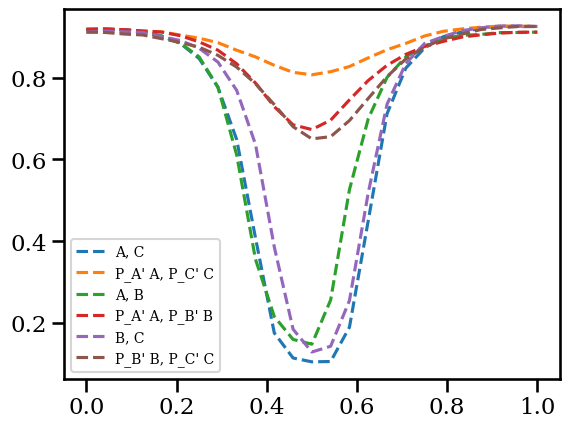

In [53]:

plot_lmc([lambdas] * 6, 
         [acc_ac, acc_a_univ_c_univ, acc_ab, acc_a_univ_b_univ, acc_bc, acc_b_univ_c_univ], 
         ['A', "P_A' A", 'A', "P_A' A", 'B', "P_B' B"], 
         ['C', "P_C' C", 'B', "P_B' B", 'C', "P_C' C"])

In [ ]:
import itertools

n = 4
steps = 15
cycles = list(itertools.combinations(list(symbols)[:-1], n-1))

output = {}

for c in cycles:
    print(f"Cycle: {c}")
    key = ''.join(c)
    model_c = cyclic_permute(pairwise_perms_gitrebasin, list(c), models)
    ordered_cycle = sorted(list(c))

    initial_model = models[ordered_cycle[0]]
    permuted_model = copy.deepcopy(initial_model)
    permuted_model.model.load_state_dict(model_c)

    print(f"Model distance: {l2_norm_models(model_c, initial_model.model.state_dict())}")

    lambdas = torch.linspace(0, 1, steps, device='cpu')
    losses, accs = get_interp_curve(lambdas, initial_model, permuted_model, ref_model)

    output[key] = {'x': lambdas.numpy(), 'loss': np.array(losses), 'acc': np.array(accs)}

np.savez('../results/git_rebasin_subcycles.npz', **output)
    

In [ ]:
output = {}

for c in cycles:
    print(f"Cycle: {c}")
    key = ''.join(c)
    model_c = cyclic_permute(pairwise_permutations, list(c), models)
    ordered_cycle = sorted(list(c))

    initial_model = models[ordered_cycle[0]]
    permuted_model = copy.deepcopy(initial_model)
    permuted_model.model.load_state_dict(model_c)

    print(f"Model distance: {l2_norm_models(model_c, initial_model.model.state_dict())}")

    lambdas = torch.linspace(0, 1, steps, device='cpu')
    losses, accs = get_interp_curve(lambdas, initial_model, permuted_model, ref_model)

    output[key] = {'x': lambdas.numpy(), 'loss': np.array(losses), 'acc': np.array(accs)}

np.savez('../results/frank_wolfe_subcycles.npz', **output)

In [76]:
'''
ordered_symbs = sorted(list(symbols))
model_current = models[ordered_symbs[0]].model.state_dict()

for i, symb in enumerate(ordered_symbs[1:] + [ordered_symbs[0]]):
    print("next: {} -- prev: {}".format(symb, ordered_symbs[i]))
    permutation = pairwise_perms_gitrebasin[symb][ordered_symbs[i]]
    model_current = apply_permutation_to_statedict(
        permutation_spec, permutation, model_current
    )
'''
model_current = cyclic_permute(pairwise_perms_gitrebasin, symbols, models)

next: b -- prev: a
next: c -- prev: b
next: d -- prev: c
next: e -- prev: d
next: a -- prev: e


In [77]:
permuted_model = copy.deepcopy(models[ordered_symbs[0]])
permuted_model.model.load_state_dict(model_current)
initial_model = models[ordered_symbs[0]]

print(f"Model distance: {l2_norm_models(permuted_model.model.state_dict(), initial_model.model.state_dict())}")

lambdas = torch.linspace(0, 1, 5, device='cpu')
losses, accs = get_interp_curve(lambdas, initial_model, permuted_model, ref_model)

print(lambdas)
print(losses)
print(accs)

Model distance: 41.915000915527344


2024-01-30 16:59:52 INFO     Evaluating interpolated model with lambda: 0.0                    ]8;id=961620;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=215536;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py#141\141]8;;\

2024-01-30 16:59:54 INFO     Evaluating interpolated model with lambda: 0.25                   ]8;id=372629;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=454074;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py#141\141]8;;\

2024-01-30 16:59:55 INFO     Evaluating interpolated model with lambda: 0.5                    ]8;id=843543;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=639044;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py#141\141]8;;\

2024-01-30 16:59:57 INFO     Evaluating interpolated model with lambda: 0.75                   ]8;id=200048;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=374218;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py#141\141]8;;\

2024-01-30 16:59:58 INFO     Evaluating interpolated model with lambda: 1.0                    ]8;id=2928;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py\ccmm.utils.utils]8;;\:]8;id=663122;file:///home/daniele/source/cycle-consistent-model-merging/src/ccmm/utils/utils.py#141\141]8;;\

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])
[0.46679627895355225, 0.4383860230445862, 2.2594735622406006, 0.45566055178642273, 0.46679627895355225]
[0.9043999910354614, 0.8659999966621399, 0.1273999959230423, 0.8679999709129333, 0.9043999910354614]


In [63]:
errs=[]
# errs2=[]
for v in pairwise_permutations['a']['b'].keys():
    P1=perm_indices_to_perm_matrix(pairwise_permutations['a']['b'][v])
    P2=perm_indices_to_perm_matrix(pairwise_permutations['b']['c'][v])
    P3=perm_indices_to_perm_matrix(pairwise_permutations['c']['d'][v])
    P4=perm_indices_to_perm_matrix(pairwise_permutations['d']['e'][v])
    P5=perm_indices_to_perm_matrix(pairwise_permutations['e']['a'][v])

    # P5=perm_indices_to_perm_matrix(pairwise_permutations['c']['a'][v])
    # P6=perm_indices_to_perm_matrix(pairwise_permutations['c']['b'][v])
    #P7=perm_indices_to_perm_matrix(pairwise_permutations['a']['c'][v])
    errs.append(((P1@P2@P3@P4@P5)-torch.eye(P4.shape[0])).abs().sum())
    # errs2.append(((P5@P1)-P6).abs().sum())

print(errs) # , print(errs2)

[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.)]
